
**This script for using CNN networks specifically for medical device digits recognition
is under commercial license for CheckMate Diabetes, Inc. and has been released
for EDUCATIONAL PURPOSES ONLY.**


In [6]:
import os
import sys
import time
import re
import datetime as dt
import imageio
import gc
import warnings
import time
import shutil

import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten, Dropout, MaxPooling2D
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model


import numpy as np
import pandas as pd
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder

from io import BytesIO
from tqdm import tqdm
from PIL import Image
from keras.models import load_model

import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('muted',color_codes=True)
warnings.filterwarnings("ignore")

In [7]:
class OCRT_model():
    
    '''
    Class for digit recognition from medical devices readings (OCRT).
    Currently trained models include single- and multi-digit recognition using a CNN.
    
    '''
    def __init__(self):
        self.model = None # model to perform inference with
        self.path_to_model = None # path to inference OCRT model
        self.x_train_mean = None # mean to subtract
        self.check_img = None # intermediate img to show how the img was preprocessed
        self.test_img = None # image which was preprocessed to be fed into the model
        self.latest_yhat = None # store the latest predicted label
        self.y_val = None # labels
        self.y_val_cat = None # labels one-hot
        self.model_type = None 
        self.num_classes = 380 #this only applies to the whole_number model
        self.categorical_offset = None
        self.test_mode = None
        
    def load_trained_model(self, path_to_model = 'trained_models/real_digit_based/'\
                           ,path_to_weights = 'trained_models/real_digit_based/',\
                           model_choice = 'Architecture_attempt_6_single_digits_20-400mgDl.h5',\
                           weights_choice = 'Single_digits_ResNet20v1_model.192.h5',\
                          path_to_train_mean = 'trained_models/real_digit_based/', \
                           train_mean = 'x_train_mean_attempt_6.npy',\
                          model_type = 'single_digit',num_classes = None):
        
        '''
        Method loads a pretrained model.
        
        ===================================
        Args:
        path_to_model: specify path to model to be loaded
        path_to_weights: specify weights of loaded model
        model_choice: specify name of the model to be loaded (gets concatenated with path_to_model)
        path_to_train_mean: 
        train_mean: specify name of the mean of used training data to be loaded 
        (gets concatenated with path_to_train_mean)
        model_type: either single_digit or whole_number to specify whether we chose a digit-by-digit
        recognition of whole number as a class recognition algorithm.
        
        ===================================
        Returns: None (model and its weight set to be class attributes)
        
        '''
        
        self.model = load_model(path_to_model + model_choice)
        self.model.load_weights(path_to_weights + weights_choice)
        self.x_train_mean = np.load(path_to_train_mean + train_mean)
        self.model_type = model_type # 'single-digit' or 
        #'whole' for CNN with a class for each reading
        if self.model_type != 'single_digit' and \
        self.model_type != 'whole_number':
            raise ValueError('You need to choose a valid model_type: \
                            either single_digit or whole_number.')
        if self.model_type == 'whole_number':
            self.num_classes = num_classes # only applies to the whole number recognition algorithm.

        
        
    def preprocess_test_images(self, path_to_images, test_mode = 'one',crop = True, save = False, preprocess=True,\
                            crop_box = (400,400,2400,2400), width = 128, height = 128,\
                            downsample_method = Image.ANTIALIAS, subtract_pixel_mean=True, categorical_offset = 40):
        '''
        Class method to preprocess images for feeding into the CNN.
        
        ===================================
        Args:
        path_to_images:
        test_mode: 
        crop: flag to specify whether to crop input image
        save: flag for saving preprocessed images
        crop_box: specify positions to create a crop box from (assuming the digit reading is roughly in
        the middle of the image)
        #### TO DO : specify crop box based on varying size of the input i.e. for different types of
        smartphone lenses.
        width, height: specs of the output downsized image
        downsample_method: a downsampling algorithm, for reference see PIL documentation for Image
        subtract_pixel_mean: flag to specify whether we subtract the mean of training image from all 
        test images (hint: True returns usually more precise results.)
        categorical_offset: applies to only whole_number predictions. Specifies how many numbers to 
        offset one-hot start (e.g., if our range starts at 20, we do categorical_offset = 20)
        
        ===================================
        Returns:
            None: all results stored as class objects.
        '''
        # start preprocessing - convert image to model-readable form
        self.test_mode = test_mode 
        self.categorical_offset = categorical_offset
        
        preprocess_start = time.time()
        
        if test_mode == 'one': # I only put in one image
            im = Image.open(path_to_images)
            if preprocess:
                # if image is side-ways, rotate it clock-wise (if it comes in as is, then leave it)
                test = imageio.imread(path_to_images) # We had to use imageio library to check shapes, 
                # as the shapes checking within PIL library was buggy.

                if test.shape[0]>test.shape[1]:
                    print('Rotating img...')
                    im = im.rotate(-90)

                if crop:
                    im = im.crop(box=crop_box)

                im = im.resize((width, height), downsample_method) 

            # store the intermediate preprocessed image to be able to display it
            self.check_img = im

            if save:
                ext = ".jpg"
                im.save(path_to_images + 'preprocessed'+ ext,"JPEG")

            # adjust image to input shape for the model
            X_data = np.array(self.check_img,dtype='float32').reshape(1, height, width, 3)

            X_data = X_data.astype('float32') / 255

            if subtract_pixel_mean:
                X_data -= self.x_train_mean

            self.test_img = X_data
        
            print(f'Time to preprocess the images was {np.around(time.time() - preprocess_start,decimals=2)} seconds.')
        
        elif test_mode == 'many':
            
            # make sure to get names of all the images I want - see the other notebooks.
            dir_list_full = [path_to_images+i for i in os.listdir(path_to_images) if i != '.DS_Store']
            
            # specify choices of downsampling algorithms
            down_sample_filters = [Image.ANTIALIAS, Image.NEAREST, Image.BILINEAR, Image.BICUBIC]
            
            obs_cnt =0
            dir_list_new = []
            # loop through directories where images are stored.
            for curr_direc in tqdm(dir_list_full):
                #print(curr_direc)
                image_names = self._get_list_of_image_names(curr_direc)
                curr_count = 0
                for image in image_names:
                        # load each image one at a time
                        obs_cnt += 1
                        curr_count += 1
            
                        ### PREPROCESSING
                        if preprocess:
                            im = Image.open(curr_direc+'/'+image)
                            test = imageio.imread(curr_direc+'/'+image)
                            #print(test.shape)
                            # rotate image if needed
                            if test.shape[0]>test.shape[1]:
                                print('Rotating img ',image)
                                im = im.rotate(-90)
                            # crop image if needed
                            if crop:
                                im = im.crop(box=crop_box)
                            # resize image if needed
                            im = im.resize((width, height), np.random.choice(down_sample_filters)) 
                            
                            # only save images if we cropped them so we can use the same flag.
                            if crop:
                                if not os.path.exists(curr_direc+'/preprocessed/'):
                                    os.makedirs(curr_direc+'/preprocessed/')
                                im.save(curr_direc + '/preprocessed/' + image ,"JPEG")
                                
                dir_list_new.append(curr_direc+'/preprocessed/')
                
            # if we did not preprocess images, we just use the original images
            if not preprocess:
                del dir_list_new
                dir_list_new = dir_list_full
            
            # load images and labels, as well as images to be checked against.
            X_data_val, y_data_val, check_imgs = self._load_images(dir_list=dir_list_new,obs=obs_cnt,check_imgs_flag=True)
            
            # Normalize data.
            X_data_val = X_data_val.astype('float32') / 255
            # If subtract pixel mean is enabled
            if subtract_pixel_mean:
                X_data_val -= self.x_train_mean
            
            self.test_img = X_data_val # store image data
            self.y_val = y_data_val # store image labels
            self.check_img = check_imgs # store images for reference
            
            # store categorical img labels, only needed for model_type = whole_number
            self.y_val_cat = keras.utils.to_categorical(self.y_val - self.categorical_offset, self.num_classes)
            print(f'Time to preprocess the images was {np.around(time.time() - preprocess_start,decimals=2)} seconds.')
                
        else:
            raise ValueError('You need to input a valid test mode: one or many.')
            

    def perform_inference_imgs(self,show_img = True, deployment = False):
        '''
        This class method performs inference on data which were previously preprocessed.
        
        Args:
        show_img: flag to display image the model predicts a label for
        
        deployment: if set to true, only records a dictionary to be sent 
        from backend to frontend {'Predicted_reading': str(predicted_label)}
        This class method assumes that in the deployment stage, we will always 
        only perform inference on images one by one.
        
        Returns: 
        Pandas Dataframe with columns ['prediction','ground_truth'] 
        to be able to compare how the prediction stands against labels.
        '''
        if self.model == None:
            raise ValueError('Need to load a model first.')
        
            
        inference_start = time.time()
        
        if self.model_type == 'single_digit':
            
            if self.test_mode == 'one':
                
                # Get current prediction for each digit
                curr_pred = self.model.predict(self.test_img)
                
                # Parse digit predictions
                digits_1, digits_2, digits_3 = self._parse_digit_predictions(curr_pred)
                
                # Concatenate the digit predictions
                overall_pred = self._concatenate_digit_predictions(digits_1, digits_2, digits_3)

                self.latest_yhat = overall_pred
                
                if deployment: # if we are in deployment mode, just return JSON-like object
                    return {'predicted_label': self.latest_yhat}
                
                print('Predicted reading: ',overall_pred,'\n')
                print(f'Time to predict image label was {np.around(time.time() - inference_start,decimals=2)} seconds.')
                print('\nDisplay preprocessed Image: \n')
                if show_img:
                    plt.imshow(self.check_img);
            
            else:
                save_preds = []
                idx = 0
                correct = 0
                total_cnt = len(self.test_img)
                
                # loop through predictions and labels and count corrent ones
                for i,ground in zip(range(len(self.test_img)),self.y_val):
                    # need to reshape the current img to match the input of the model
                    curr_pred = self.model.predict(self.test_img[i].reshape(1,128,128,3))
                    digits_1, digits_2, digits_3 = self._parse_digit_predictions(curr_pred)
                    overall_pred = self._concatenate_digit_predictions(digits_1, digits_2, digits_3)
                    save_preds.append(overall_pred)
                    if overall_pred == str(ground):
                        correct+=1
                    else:
                        # Always print incorrect predictions
                        print('Prediction: ', overall_pred, ' ground truth: ',ground, 'at index: ',idx)
                    idx +=1
                
                print('Accuracy: ',np.around(correct/total_cnt,decimals = 4)*100,'%.')
                
                to_display = {}
                to_display['prediction'] = save_preds
                to_display['ground_truth'] = self.y_val
                df_eval = pd.DataFrame(to_display)
                cols=['ground_truth','prediction']
                df_eval = df_eval[cols]
                
                print(f'Time to predict image label was {np.around(time.time() - inference_start,decimals=2)} seconds.')
                
                return df_eval
            
        elif self.model_type == 'whole_number':
            
            if self.test_mode == 'one':
                
                if deployment: # if we are in deployment mode, just return JSON-like object
                    return {'predicted_label': self.latest_yhat}
                
                print('Predicted reading: ', np.argmax(self.model.predict(self.test_img.reshape(1,128,128,3))) + self.categorical_offset, '\n')
                print(f'Time to predict image label was {np.around(time.time() - inference_start,decimals=2)} seconds.')
                print('\nDisplay preprocessed Image: \n')
                if show_img:
                    plt.imshow(self.check_img);
            
            else:
                save_preds = []
                idx = 0
                correct = 0
                total_cnt = len(self.test_img)
                for i,ground in zip(range(len(self.test_img)), self.y_val):
                    curr_pred = np.argmax(self.model.predict(self.test_img[i].reshape(1,128,128,3))) + self.categorical_offset
                    save_preds.append(curr_pred)
                    if str(curr_pred) == str(ground):
                        correct+=1
                    else:
                        print('Prediction: ', curr_pred, ' ground truth: ',ground, 'at index: ',idx)
                    idx +=1
                
                print('Accuracy: ',np.around(correct/total_cnt,decimals = 4)*100,'%.')
                
                to_display = {}
                to_display['prediction'] = save_preds
                to_display['ground_truth'] = self.y_val
                df_eval = pd.DataFrame(to_display)
                cols=['ground_truth','prediction']
                df_eval = df_eval[cols]
                
                print(f'Time to predict image label was {np.around(time.time() - inference_start,decimals=2)} seconds.')
                
                return df_eval
                    
    def _parse_digit_predictions(self,predictions):
        '''
        Parse digit predictions from the single-digits model. Excludes length prediction.
        Works for either one or multiple images.
        
        ===================================
        Args:
        predictions: list of lists of probabiities for each digit
        
        ===================================
        Returns:
        digits_1 , digits_2, digits_3 : first, second, and third digit outputted with
        highest probability from the model.
        '''
        cnt =0
        digits_1 , digits_2, digits_3 = [], [], []

        for digit in predictions[1:]: # loop through 3 arrays of digit predictions

            for current_number_prob in digit: # loop through array for each digit and save max prob
                if cnt ==0:
                    digits_1.append(np.argmax(current_number_prob))
                elif cnt == 1:
                    digits_2.append(np.argmax(current_number_prob))
                elif cnt == 2:
                    digits_3.append(np.argmax(current_number_prob))
            cnt += 1
        return digits_1 , digits_2, digits_3
    
    def _concatenate_digit_predictions(self, digits_1, digits_2, digits_3):
        '''
        Concatenates preprocessed digits predictions via _parse_digit_prediction method.
        
        ===================================
        Args:
        digits_1 , digits_2, digits_3 : first, second, and third digit predicted by the model
        
        ===================================
        Returns:
        Overall concatenated prediction of digit, type str
        '''
        total_cnt = len(digits_1)
        correct = 0
        idx = 0
        for i, j, k in zip(digits_1, digits_2, digits_3):
            if i == 0:
                pred = ''.join([str(j),str(k)])
            else:
                pred = ''.join([str(i),str(j),str(k)])
        
        return pred
    
    def _get_list_of_image_names(self,direct):
        '''
        Returns a list of image names in a given directory.
        '''
        candidate_files = os.listdir(direct)
        images = []
        for file in candidate_files:
            if file[-3:].lower() == 'jpg':
                images.extend([file])
        return images

    def _load_images(self,dir_list,obs,height=128,width=128, check_imgs_flag=False):
        '''
        Load the existing images into the environment
        and assign labels.
        
        Note: the class method assumes the image data is only one directory "deeper" than the current script.
        '''

        labels = []
        total_cnt = 0
        check_imgs = []
        # pre-allocate numpy array for img data
        X_data = np.zeros((obs,height,width,3),dtype='float32')

        for curr_direc in tqdm(dir_list):

            image_names = self._get_list_of_image_names(curr_direc)

            cnt = 0 # start incrementing the count of directories
            labels_cnt = 0
            for image in image_names:
                # load each image one at a time
                loaded_image = imageio.imread(curr_direc+'/'+image)

    #             if cnt%2==0: # only do odd number of images to decrease dataset size
                    # cast to a numpy array
                if check_imgs_flag:
                    check_imgs.append(loaded_image)
                converted_image = np.array(loaded_image,dtype='float32')

                #converted_image = np.resize(loaded_image,(3,128,128))
                X_data[total_cnt]= converted_image
                total_cnt+=1
                labels_cnt+=1
                cnt+=1
                #del loaded_image
                #gc.collect()

            # beginning of the directory name, assumes that our label (number) is only one directory deeper
            # than current script
            labels.extend([curr_direc.split('/')[1]]*labels_cnt)
        y_data = np.array(labels,dtype='int32')
        #print(check_imgs)
        if check_imgs_flag:
            return X_data,y_data, check_imgs
        else:
            return X_data,y_data
    
    
    def train_model(self):
        
        raise NotImplementedError('Training method has not been implemented for this class.')

## Load model and weights

In [8]:
# Default is the single-digit model:
ocrt_digits = OCRT_model()

ocrt_digits.load_trained_model(model_type='single_digit')



## Model 1 - Single Digits

### Predict reading value - single image - load raw numbers

Rotating img...
Time to preprocess the images was 0.58 seconds.
--------------------------------------------------
Predicted reading:  141 

Time to predict image label was 0.27 seconds.

Display preprocessed Image: 



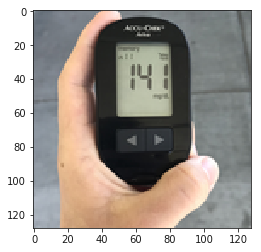

In [9]:
## Model 1 - Single digits prediction

ocrt_digits.preprocess_test_images(path_to_images='raw_numbers/141/IMG_0939.JPG',test_mode='one',save=False,\
                                   preprocess=True,crop_box=(700,600,2700,2600))

print('-'*50)
ocrt_digits.perform_inference_imgs(show_img=True, deployment=False)

Rotating img...
Time to preprocess the images was 0.55 seconds.
--------------------------------------------------
Predicted reading:  123 

Time to predict image label was 0.07 seconds.

Display preprocessed Image: 



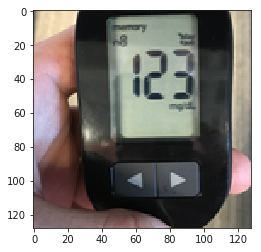

In [5]:
## Model 1 - Single digits prediction

ocrt_digits.preprocess_test_images(path_to_images='raw_numbers/123/IMG_0225.JPG',test_mode='one',save=False,\
                                   preprocess=True,crop_box=(700,600,2700,2600))

print('-'*50)
ocrt_digits.perform_inference_imgs(show_img=True, deployment=False)

### Get model accuracy on a batch of images

In [7]:
## Model 1 - Single digits prediction

# need to make sure the crop box gathers all the displays!
# if not preprocessed images yet, make sure preprocess flag is True!
ocrt_digits.preprocess_test_images(path_to_images='raw_numbers/',\
                                   test_mode='many',save=False,preprocess = True,\
                                   crop_box = (700,600,2700,2600))

  0%|          | 0/12 [00:00<?, ?it/s]

Rotating img  IMG_0936.JPG
Rotating img  IMG_0922.JPG
Rotating img  IMG_0923.JPG
Rotating img  IMG_0921.JPG
Rotating img  IMG_0935.JPG
Rotating img  IMG_0934.JPG
Rotating img  IMG_0920.JPG
Rotating img  IMG_0924.JPG
Rotating img  IMG_0930.JPG
Rotating img  IMG_0918.JPG
Rotating img  IMG_0919.JPG
Rotating img  IMG_0931.JPG
Rotating img  IMG_0925.JPG
Rotating img  IMG_0933.JPG
Rotating img  IMG_0927.JPG
Rotating img  IMG_0926.JPG
Rotating img  IMG_0932.JPG
Rotating img  IMG_0917.JPG
Rotating img  IMG_0928.JPG
Rotating img  IMG_0914.JPG
Rotating img  IMG_0915.JPG
Rotating img  IMG_0929.JPG


  8%|▊         | 1/12 [00:10<01:52, 10.23s/it]

Rotating img  IMG_0549.JPG
Rotating img  IMG_0548.JPG
Rotating img  IMG_0705.JPG
Rotating img  IMG_0513.JPG
Rotating img  IMG_0507.JPG
Rotating img  IMG_0671.JPG
Rotating img  IMG_0506.JPG
Rotating img  IMG_0512.JPG
Rotating img  IMG_0704.JPG
Rotating img  IMG_0504.JPG
Rotating img  IMG_0510.JPG
Rotating img  IMG_0538.JPG
Rotating img  IMG_0699.JPG
Rotating img  IMG_0672.JPG
Rotating img  IMG_0673.JPG
Rotating img  IMG_0698.JPG
Rotating img  IMG_0539.JPG
Rotating img  IMG_0511.JPG
Rotating img  IMG_0505.JPG
Rotating img  IMG_0703.JPG
Rotating img  IMG_0529.JPG
Rotating img  IMG_0515.JPG
Rotating img  IMG_0688.JPG
Rotating img  IMG_0677.JPG
Rotating img  IMG_0676.JPG
Rotating img  IMG_0689.JPG
Rotating img  IMG_0514.JPG
Rotating img  IMG_0528.JPG
Rotating img  IMG_0702.JPG
Rotating img  IMG_0700.JPG
Rotating img  IMG_0516.JPG
Rotating img  IMG_0674.JPG
Rotating img  IMG_0675.JPG
Rotating img  IMG_0503.JPG
Rotating img  IMG_0517.JPG
Rotating img  IMG_0701.JPG
Rotating img  IMG_0532.JPG
R

 17%|█▋        | 2/12 [00:50<04:11, 25.15s/it]

Rotating img  IMG_0667.JPG
Rotating img  IMG_0661.JPG
Rotating img  IMG_0477.JPG
Rotating img  IMG_0669.JPG
Rotating img  IMG_0668.JPG
Rotating img  IMG_0481.JPG


 25%|██▌       | 3/12 [00:53<02:39, 17.70s/it]

Rotating img  IMG_0909.JPG
Rotating img  IMG_0908.JPG
Rotating img  IMG_0903.JPG
Rotating img  IMG_0902.JPG
Rotating img  IMG_0900.JPG
Rotating img  IMG_0901.JPG
Rotating img  IMG_0905.JPG
Rotating img  IMG_0911.JPG
Rotating img  IMG_0910.JPG
Rotating img  IMG_0904.JPG
Rotating img  IMG_0912.JPG
Rotating img  IMG_0906.JPG
Rotating img  IMG_0899.JPG
Rotating img  IMG_0907.JPG
Rotating img  IMG_0913.JPG


 33%|███▎      | 4/12 [01:00<02:00, 15.02s/it]

Rotating img  IMG_0299.JPG
Rotating img  IMG_0310.JPG
Rotating img  IMG_0297.JPG
Rotating img  IMG_0293.JPG


 42%|████▏     | 5/12 [01:01<01:26, 12.38s/it]

Rotating img  IMG_0856.JPG
Rotating img  IMG_0880.JPG
Rotating img  IMG_0857.JPG
Rotating img  IMG_0869.JPG
Rotating img  IMG_0855.JPG
Rotating img  IMG_0854.JPG
Rotating img  IMG_0868.JPG
Rotating img  IMG_0878.JPG
Rotating img  IMG_0879.JPG
Rotating img  IMG_0863.JPG
Rotating img  IMG_0877.JPG
Rotating img  IMG_0876.JPG
Rotating img  IMG_0862.JPG
Rotating img  IMG_0874.JPG
Rotating img  IMG_0860.JPG
Rotating img  IMG_0861.JPG
Rotating img  IMG_0875.JPG
Rotating img  IMG_0871.JPG
Rotating img  IMG_0865.JPG
Rotating img  IMG_0859.JPG
Rotating img  IMG_0858.JPG
Rotating img  IMG_0864.JPG
Rotating img  IMG_0870.JPG
Rotating img  IMG_0866.JPG
Rotating img  IMG_0872.JPG
Rotating img  IMG_0873.JPG
Rotating img  IMG_0867.JPG


 50%|█████     | 6/12 [01:13<01:13, 12.31s/it]

Rotating img  IMG_0389.JPG
Rotating img  IMG_0404.JPG
Rotating img  IMG_0410.JPG
Rotating img  IMG_0376.JPG
Rotating img  IMG_0411.JPG
Rotating img  IMG_0377.JPG
Rotating img  IMG_0405.JPG
Rotating img  IMG_0388.JPG
Rotating img  IMG_0759.JPG
Rotating img  IMG_0375.JPG
Rotating img  IMG_0413.JPG
Rotating img  IMG_0407.JPG
Rotating img  IMG_0406.JPG
Rotating img  IMG_0374.JPG
Rotating img  IMG_0412.JPG
Rotating img  IMG_0758.JPG
Rotating img  IMG_0748.JPG
Rotating img  IMG_0760.JPG
Rotating img  IMG_0416.JPG
Rotating img  IMG_0370.JPG
Rotating img  IMG_0402.JPG
Rotating img  IMG_0403.JPG
Rotating img  IMG_0417.JPG
Rotating img  IMG_0371.JPG
Rotating img  IMG_0749.JPG
Rotating img  IMG_0398.JPG
Rotating img  IMG_0401.JPG
Rotating img  IMG_0373.JPG
Rotating img  IMG_0372.JPG
Rotating img  IMG_0414.JPG
Rotating img  IMG_0400.JPG
Rotating img  IMG_0399.JPG
Rotating img  IMG_0739.JPG
Rotating img  IMG_0738.JPG
Rotating img  IMG_0753.JPG
Rotating img  IMG_0747.JPG
Rotating img  IMG_0380.JPG
R

 58%|█████▊    | 7/12 [01:47<01:16, 15.32s/it]

Rotating img  IMG_0881.JPG
Rotating img  IMG_0895.JPG
Rotating img  IMG_0894.JPG
Rotating img  IMG_0896.JPG
Rotating img  IMG_0882.JPG
Rotating img  IMG_0883.JPG
Rotating img  IMG_0897.JPG
Rotating img  IMG_0893.JPG
Rotating img  IMG_0887.JPG
Rotating img  IMG_0886.JPG
Rotating img  IMG_0892.JPG
Rotating img  IMG_0884.JPG
Rotating img  IMG_0890.JPG
Rotating img  IMG_0891.JPG
Rotating img  IMG_0885.JPG
Rotating img  IMG_0888.JPG
Rotating img  IMG_0889.JPG
Rotating img  IMG_0898.JPG


 67%|██████▋   | 8/12 [01:56<00:58, 14.50s/it]

Rotating img  IMG_0229.JPG
Rotating img  IMG_0228.JPG
Rotating img  IMG_0261.JPG
Rotating img  IMG_0249.JPG
Rotating img  IMG_0248.JPG
Rotating img  IMG_0260.JPG
Rotating img  IMG_0258.JPG
Rotating img  IMG_0259.JPG
Rotating img  IMG_0254.JPG
Rotating img  IMG_0255.JPG
Rotating img  IMG_0243.JPG
Rotating img  IMG_0257.JPG
Rotating img  IMG_0256.JPG
Rotating img  IMG_0242.JPG
Rotating img  IMG_0246.JPG
Rotating img  IMG_0252.JPG
Rotating img  IMG_0253.JPG
Rotating img  IMG_0247.JPG
Rotating img  IMG_0251.JPG
Rotating img  IMG_0245.JPG
Rotating img  IMG_0244.JPG
Rotating img  IMG_0250.JPG
Rotating img  IMG_0234.JPG
Rotating img  IMG_0235.JPG
Rotating img  IMG_0225.JPG
Rotating img  IMG_0231.JPG
Rotating img  IMG_0230.JPG
Rotating img  IMG_0232.JPG
Rotating img  IMG_0226.JPG
Rotating img  IMG_0227.JPG
Rotating img  IMG_0233.JPG


 75%|███████▌  | 9/12 [02:10<00:43, 14.51s/it]

Rotating img  IMG_0425.JPG


 83%|████████▎ | 10/12 [02:11<00:26, 13.10s/it]

Rotating img  IMG_0955.JPG
Rotating img  IMG_0941.JPG
Rotating img  IMG_0940.JPG
Rotating img  IMG_0954.JPG
Rotating img  IMG_0942.JPG
Rotating img  IMG_0956.JPG
Rotating img  IMG_0943.JPG
Rotating img  IMG_0947.JPG
Rotating img  IMG_0953.JPG
Rotating img  IMG_0952.JPG
Rotating img  IMG_0946.JPG
Rotating img  IMG_0950.JPG
Rotating img  IMG_0944.JPG
Rotating img  IMG_0945.JPG
Rotating img  IMG_0951.JPG
Rotating img  IMG_0937.JPG
Rotating img  IMG_0939.JPG
Rotating img  IMG_0938.JPG
Rotating img  IMG_0948.JPG
Rotating img  IMG_0949.JPG


 92%|█████████▏| 11/12 [02:20<00:12, 12.74s/it]

Rotating img  IMG_0835.JPG
Rotating img  IMG_0834.JPG
Rotating img  IMG_0836.JPG
Rotating img  IMG_0837.JPG
Rotating img  IMG_0833.JPG
Rotating img  IMG_0832.JPG
Rotating img  IMG_0275.JPG
Rotating img  IMG_0842.JPG
Rotating img  IMG_0843.JPG
Rotating img  IMG_0274.JPG
Rotating img  IMG_0289.JPG
Rotating img  IMG_0262.JPG
Rotating img  IMG_0276.JPG
Rotating img  IMG_0841.JPG
Rotating img  IMG_0840.JPG
Rotating img  IMG_0277.JPG
Rotating img  IMG_0263.JPG
Rotating img  IMG_0288.JPG
Rotating img  IMG_0273.JPG
Rotating img  IMG_0850.JPG
Rotating img  IMG_0844.JPG
Rotating img  IMG_0845.JPG
Rotating img  IMG_0851.JPG
Rotating img  IMG_0272.JPG
Rotating img  IMG_0266.JPG
Rotating img  IMG_0270.JPG
Rotating img  IMG_0264.JPG
Rotating img  IMG_0847.JPG
Rotating img  IMG_0853.JPG
Rotating img  IMG_0852.JPG
Rotating img  IMG_0846.JPG
Rotating img  IMG_0265.JPG
Rotating img  IMG_0271.JPG
Rotating img  IMG_0283.JPG
Rotating img  IMG_0268.JPG
Rotating img  IMG_0269.JPG
Rotating img  IMG_0282.JPG
R

100%|██████████| 12/12 [00:00<00:00, 44.60it/s]


Time to preprocess the images was 164.24 seconds.


In [8]:
df_comparison = ocrt_digits.perform_inference_imgs()

Prediction:  124  ground truth:  93 at index:  68
Prediction:  41  ground truth:  141 at index:  299
Accuracy:  99.44 %.
Time to predict image label was 18.95 seconds.


In [11]:
df_comparison.head()

,ground_truth,prediction
0,168,168
1,168,168
2,168,168
3,168,168
4,168,168


In [14]:
## Model 1 - Single digits prediction

# need to make sure the crop box gathers all the displays!
# if not preprocessed images yet, make sure preprocess flag is True!
ocrt_digits.preprocess_test_images(path_to_images='raw_numbers2/',\
                                   test_mode='many',save=False,preprocess = True,\
                                   crop_box = (700,600,2700,2600))

  0%|          | 0/3 [00:00<?, ?it/s]

Rotating img  IMG_1031.JPG
Rotating img  IMG_1030.JPG
Rotating img  IMG_1032.JPG
Rotating img  IMG_1029.JPG


 33%|███▎      | 1/3 [00:01<00:03,  1.84s/it]

Rotating img  IMG_1037.JPG
Rotating img  IMG_1034.JPG
Rotating img  IMG_1035.JPG


 67%|██████▋   | 2/3 [00:03<00:01,  1.61s/it]

Rotating img  IMG_1040.JPG
Rotating img  IMG_1041.JPG
Rotating img  IMG_1043.JPG
Rotating img  IMG_1042.JPG
Rotating img  IMG_1046.JPG
Rotating img  IMG_1047.JPG
Rotating img  IMG_1045.JPG
Rotating img  IMG_1044.JPG
Rotating img  IMG_1039.JPG
Rotating img  IMG_1049.JPG
Rotating img  IMG_1048.JPG


100%|██████████| 3/3 [00:00<00:00, 250.79it/s]

Time to preprocess the images was 8.32 seconds.


In [15]:
df_comparison = ocrt_digits.perform_inference_imgs()

Accuracy:  100.0 %.
Time to predict image label was 0.97 seconds.


In [16]:
df_comparison

,ground_truth,prediction
0,168,168
1,168,168
2,168,168
3,168,168
4,130,130
5,130,130
6,130,130
7,122,122
8,122,122
9,122,122
